In [1]:
import numpy as np
import scipy
import scipy.special as sp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from domain_class import domain

## Define Standard Units
fsize = 22
tsize = 15
tdir = 'in'
major = 5
minor = 3
style = 'default'

params = {
    'figure.figsize': (15,12),
    'savefig.dpi': 75,
    'text.usetex': False,
    'font.size': fsize,
    'legend.fontsize': tsize,
    'legend.title_fontsize': tsize,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral',    
    'axes.labelsize':15,
    'axes.titlesize':20,
    'lines.linewidth':2.5,
    'axes.grid': False,
    'axes.labelweight':'bold',
    'legend.loc': 'upper right',
    'xtick.labelsize':'x-small',
    'ytick.labelsize':'x-small',
}
plt.rcParams.update(params)

In [2]:
size = 1
planes = {'xy'}
d = domain(size, planes)
cart_grids = d.cart_grid()
xy_grid = cart_grids['xy']
xy_grid.shape

(2, 300, 300)

In [52]:
leg = sp.assoc_legendre_p_all(2,2, xy_grid[0], norm = False)

In [53]:
leg = leg[0,:,:3]
leg.shape

(3, 3, 300, 300)

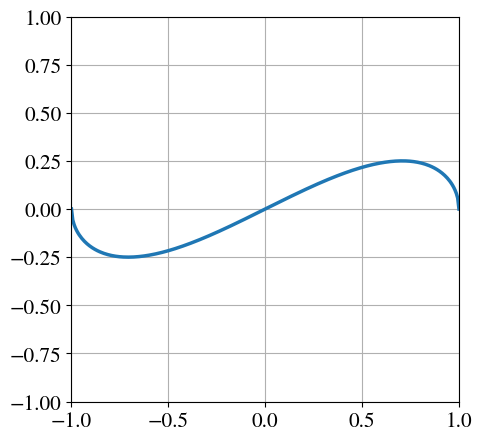

In [44]:
#plot the legendre polynomials along x - one dimension
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(xy_grid[0][:,0], leg[0,2,4,:,0], label=f'P{n}(x)')
ax.set(xlim=(-1,1), ylim=(-1,1))
ax.grid(True)

In [64]:
#initialize domain
size = 1
planes = {'xy', 'yz'}
d = domain(size, planes)
pol = d.spherical_grid()
pol.keys()
pol['xy'].shape

(3, 300, 300)

In [ ]:
class Multipoles:
    def __init__(self, spherical_grids, j):
        self.cart_grids = self.d.cart_grid()
        
        #get planes
        self.planes = spherical_grids.keys()
                            
        
        self.leg = sp.assoc_legendre_p_all(2,2, self.xy_grid[0], norm = False)
        self.leg = self.leg[0,:,:

In [ ]:
class Multipoles:
    def __init__(self, l, m, wl, spherical_grids):
        self.l = l
        self.m = m
        self.wl = wl
        self.spherical_grids = spherical_grids
        
        #other initialized variables
        self.wn = 2 * np.pi / wl
        self.planes = spherical_grids.keys()
        
        self.R = np.concatenate([spherical_grids[key][0] for key in spherical_grids.keys()])
        self.Theta = np.concatenate([spherical_grids[key][1] for key in spherical_grids.keys()])
        self.Phi = np.concatenate([spherical_grids[key][2] for key in spherical_grids.keys()])
        
        self.Leg = self.get_Legendre(l, m, self.Theta)
        self.dLeg = self.get_Legendre(l, m, self.Theta, diff = True)
        
    @staticmethod
    def Clp(l):
        return -1j * np.sqrt(l / (2 * l + 1))

    @staticmethod
    def Clm(l):
        return 1j * np.sqrt((l + 1) / (2 * l + 1))

    @staticmethod
    def Cl0(l):
        return -1j

    @staticmethod
    def hankel(n, x, derivative=False):
        if not derivative:
            return sp.spherical_jn(n, x) + 1j * sp.spherical_yn(n, x)
        else:
            return sp.spherical_jn(n, x, derivative=True) + 1j * sp.spherical_yn(n, x, derivative=True)

    @staticmethod
    def clebsch_gordan(j1, j2, j, m1, m2, m):
        if any(2 * x != int(2 * x) for x in [j1, j2, j, m1, m2, m]):
            raise ValueError('All arguments must be integers or half-integers.')

        if m1 + m2 != m:
            return 0

        if not (j1 - m1 == int(j1 - m1)):
            return 0

        if not (j2 - m2 == int(j2 - m2)):
            return 0

        if not (j - m == int(j - m)):
            return 0

        if j > j1 + j2 or j < abs(j1 - j2):
            return 0

        if abs(m1) > j1:
            return 0

        if abs(m2) > j2:
            return 0

        if abs(m) > j:
            return 0

        m = float(m)
        cg = (-1) ** (j1 - j2 + m) * np.sqrt(2 * j + 1) * Multipoles.wigner_3j([j1, j2, j], [m1, m2, -m])
        return cg

    @staticmethod
    def wigner_3j(j123, m123):
        j1, j2, j3 = j123
        m1, m2, m3 = m123

        if any(np.array(j123) < 0):
            raise ValueError('The j values must be non-negative')
        elif any(np.mod(np.array(j123 + m123), 0.5) != 0):
            raise ValueError('All arguments must be integers or half-integers')
        elif any(np.mod(np.array(j123) - np.array(m123), 1) != 0):
            raise ValueError('j123 and m123 do not match')

        if (j3 > (j1 + j2)) or (j3 < abs(j1 - j2)) or (m1 + m2 + m3 != 0) or any(np.abs(m123) > j123):
            return 0

        if all(m == 0 for m in m123) and np.mod(np.sum(j123), 2) != 0:
            return 0

        t1 = j2 - m1 - j3
        t2 = j1 + m2 - j3
        t3 = j1 + j2 - j3
        t4 = j1 - m1
        t5 = j2 + m2

        tmin = max(0, max(t1, t2))
        tmax = min(t3, min(t4, t5))

        t = np.arange(tmin, tmax + 1)

        gam1 = -np.ones(6) @ np.gammaln(np.array([t, t - t1, t - t2, t3 - t, t4 - t, t5 - t]) + 1)
        gam2 = np.gammaln(np.array([j1 + j2 + j3 + 1, j1 + j2 - j3, j1 - j2 + j3, -j1 + j2 + j3,
                                    j1 + m1, j1 - m1, j2 + m2, j2 - m2, j3 + m3, j3 - m3]) + 1)

        gam2 = gam2 @ np.array([-1] + [1] * 9) * 0.5

        gamsum = np.squeeze(np.add.outer(gam1, gam2))

        w = np.sum((-1) ** t * np.exp(gamsum)) * (-1) ** (j1 - j2 - m3)

        if np.isnan(w):
            print('Warning: Wigner3J is NaN!')
        elif np.isinf(w):
            print('Warning: Wigner3J is Inf!')
        return w

    def vsh(self, j, l, m, theta, phi):
        """Calculate value of vector spherical harmonics for given j, l, m, theta, phi.

        Args:
            j (int): total angular momentum
            l (int): orbital angular momentum
            m (int): Jz 
            theta (array of floats): Grid array of theta values
            phi (array of floats): Grid of phi values
        
        Returns:
            VSH (array of floats): Grid array of vector spherical harmonics values  
        """
        cp = self.clebsch_gordan(l, 1, j, m - 1, 1, m)
        c0 = self.clebsch_gordan(l, 1, j, m, 0, m)
        cm = self.clebsch_gordan(l, 1, j, m + 1, -1, m)

        M = np.array([(cp != 0) * (m - 1), (c0 != 0) * m, (cm != 0) * (m + 1)])

        Y = np.array([self.spharm(l, m_val, theta, phi, Leg) for m_val in M])

        Ap = cp * Y[0, :]
        A0 = c0 * Y[1, :]
        Am = cm * Y[2, :]

        return Ap, A0, Am

    def spharm(self, l, m, theta, phi, leg):
        sgn = -2 * ((m < 0) - 0.5)
        m = abs(m)
        Leg = leg[m, l]
        e = np.exp(1j * (sgn * m) * phi)

        Y = Leg * e / np.sqrt(2 * np.pi)

        u = np.where((sgn < 0) & (m % 2 != 0))
        Y[u] = -Y[u]

        return Y

    def get_Legendre(self, l, m, theta, norm = True, diff = False):
        """Calculate the associated Legendre functions up to degree l and order m.

        Args:
            l (int): Degree of the Legendre function
            m (int): Order of the Legendre function
            theta (array_like): Array of coordinates
            norm (bool, optional): Use the normalized Legendre function. Defaults to True.
            diff (bool, optional): Use the derivative of the Legendre function. Defaults to False.

        Returns:
            Array: (m+1,l+1, len(theta))
        """
        Leg = sp.assoc_legendre_p_all(m, l, theta, norm = norm, diff = diff)
        Leg = Leg[0,:,:3] # sp returns shape (1, m+1, 2l+1, len(theta))
        
        return Leg

    def calculate_multipoles(self):
        P = np.zeros(3, dtype=complex)
        Z = np.zeros(3, dtype=complex)
        M = np.zeros(3, dtype=complex)

        for i in range(3):
            Ap1, A01, Am1 = self.vsh(self.l, self.l, self.m, self.Theta[i], self.Phi[i], leg)
            Alp_m_p = self.Cl0(self.l) * sp.spherical_jn(self.l, self.wn * self.R[i]) * Ap1
            Alp_m_0 = self.Cl0(self.l) * sp.spherical_jn(self.l, self.wn * self.R[i]) * A01
            Alp_m_m = self.Cl0(self.l) * sp.spherical_jn(self.l, self.wn * self.R[i]) * Am1

            Ap2, A02, Am2 = self.vsh(self.l, self.l + 1, self.m, self.Theta[i], self.Phi[i], leg)
            Ap3, A03, Am3 = self.vsh(self.l, self.l - 1, self.m, self.Theta[i], self.Phi[i], leg)

            Alp_e_p = self.Clp(self.l) * sp.spherical_jn(self.l + 1, self.wn * self.R[i]) * Ap2 + self.Clm(self.l) * sp.spherical_jn(self.l - 1, self.wn * self.R[i]) * Ap3
            Alp_e_0 = self.Clp(self.l) * sp.spherical_jn(self.l + 1, self.wn * self.R[i]) * A02 + self.Clm(self.l) * sp.spherical_jn(self.l - 1, self.wn * self.R[i]) * A03
            Alp_e_m = self.Clp(self.l) * sp.spherical_jn(self.l + 1, self.wn * self.R[i]) * Am2 + self.Clm(self.l) * sp.spherical_jn(self.l - 1, self.wn * self.R[i]) * Am3

            P[i] = Alp_e_p
            Z[i] = Alp_e_0
            M[i] = Alp_e_m

        return P, Z, M

    def calculate_hankel_multipoles(self):
        P = np.zeros(3, dtype=complex)
        Z = np.zeros(3, dtype=complex)
        M = np.zeros(3, dtype=complex)

        for i in range(3):
            Ap1, A01, Am1 = self.vsh(self.l, self.l, self.m, self.Theta[i], self.Phi[i], leg)
            Alp_m_p = self.Cl0(self.l) * self.hankel(self.l, self.wn * self.R[i]) * Ap1
            Alp_m_0 = self.Cl0(self.l) * self.hankel(self.l, self.wn * self.R[i]) * A01
            Alp_m_m = self.Cl0(self.l) * self.hankel(self.l, self.wn * self.R[i]) * Am1

            Ap2, A02, Am2 = self.vsh(self.l, self.l + 1, self.m, self.Theta[i], self.Phi[i], leg)
            Ap3, A03, Am3 = self.vsh(self.l, self.l - 1, self.m, self.Theta[i], self.Phi[i], leg)

            Alp_e_p = self.Clp(self.l) * self.hankel(self.l + 1, self.wn * self.R[i]) * Ap2 + self.Clm(self.l) * self.hankel(self.l - 1, self.wn * self.R[i]) * Ap3
            Alp_e_0 = self.Clp(self.l) * self.hankel(self.l + 1, self.wn * self.R[i]) * A02 + self.Clm(self.l) * self.hankel(self.l - 1, self.wn * self.R[i]) * A03
            Alp_e_m = self.Clp(self.l) * self.hankel(self.l + 1, self.wn * self.R[i]) * Am2 + self.Clm(self.l) * self.hankel(self.l - 1, self.wn * self.R[i]) * Am3

            P[i] = Alp_e_p
            Z[i] = Alp_e_0
            M[i] = Alp_e_m

        return P, Z, M
